In [8]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
from collections import namedtuple
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Extraction Phase

In [2]:
walker = 'https://www.remax.com/homes-for-sale/tx/walker-county/county/48471'
montgomery = 'https://www.remax.com/homes-for-sale/tx/montgomery-county/county/48339'
grimes = 'https://www.remax.com/homes-for-sale/tx/grimes-county/county/48185'
waller = 'https://www.remax.com/homes-for-sale/tx/waller-county/county/48473'
liberty = 'https://www.remax.com/homes-for-sale/tx/liberty-county/county/48291'
polk = 'https://www.remax.com/homes-for-sale/tx/polk-county/county/48373'
san_jacinto = 'https://www.remax.com/homes-for-sale/tx/san-jacinto-county/county/48407'
counties = [walker,montgomery,grimes,waller,liberty,polk,san_jacinto]

In [65]:
for county in counties:
    print(county)

['https://www.remax.com/homes-for-sale/tx/walker-county/county/48471']
['https://www.remax.com/homes-for-sale/tx/montgomery-county/county/48339']
['https://www.remax.com/homes-for-sale/tx/grimes-county/county/48185']
['https://www.remax.com/homes-for-sale/tx/waller-county/county/48473']
['https://www.remax.com/homes-for-sale/tx/liberty-county/county/48291']
['https://www.remax.com/homes-for-sale/tx/polk-county/county/48373']
['https://www.remax.com/homes-for-sale/tx/san-jacinto-county/county/48407']


In [66]:

def getRealEstate(url):
    driver = webdriver.Firefox()
    driver.get(url)

    cookies = driver.find_element(By.XPATH, '//button[@class="modal-cookie-only-necessary-button dbutton dbutton-remax outline"]')
    driver.execute_script("arguments[0].click();",cookies)
    post = []
    stop = True
    counter = 1

    while stop != False:


        html_doc = requests.get(f'{url}/page-'+ str(counter)).text
        soup = BeautifulSoup(html_doc,'html.parser') 
        post.extend(soup.find_all('div',class_='card-details'))
        try:
            ignored_exceptions=(StaleElementReferenceException)
            next = WebDriverWait(driver, 30,ignored_exceptions=ignored_exceptions)\
                   .until(expected_conditions.presence_of_element_located((By.XPATH, '//a[@aria-label="Next Page"]')))
            next.click()
            counter = counter + 1
            
           
                
        except ElementClickInterceptedException:
            driver.close()
            stop = False
    return post

In [73]:
posts = []
for county in counties:
    posts.extend(getRealEstate(county))

In [62]:
#Get Price
def getStats(posts):
    cards = []
    for element in posts:
        for card in element.find_all('div', class_='card-details-stats'):
            beds = card.contents[2].text[:1]
            baths = card.contents[4].text[:1]
            if card.find(string='Acres'):
                acres = card.contents[6].text[:-7].replace(',','').strip()
                sqft=''
            else:
                acres = ''
                sqft = card.contents[6].text[:-6].replace(',','')
        
        address = element.find('h5').contents[0].text
        city = element.find('h5').contents[1].text[1:-10].strip()
        state = element.find('h5').contents[1].text[-8:-6]
        zipCode = element.find('h5').contents[1].text[-6:].strip()
        price = element.find('h4', class_='price').text[10:-7].replace(',','')
        cards.append({'Price':int(price), 'Address':address,'City':city,'State':state,'ZipCode':int(zipCode),'Beds':beds,'Baths':baths,'Sqft':sqft, 'Acres':acres})
    
    return cards


In [63]:
cards = getStats(posts)

EXPLORATORY DATA ANALYSIS

In [77]:
#Get Square Footage
properties = pd.DataFrame(data=cards)

In [21]:
properties.head(10)

,Price,Address,City,State,ZipCode,Beds,Baths,Sqft,Acres
0,160000,1-3-73 WINCHESTER ROAD,HUNTSVILLE,TX,77340,0,0,0,2.06
1,95000,7-23-67 SKY OAK LANE,HUNTSVILLE,TX,77340,0,0,0,1.00
2,419000,706 QUAIL HOLLOW DR,HUNTSVILLE,TX,77340,3,3,2516,0.00
3,159000,2-10-17 STAGECOACH CIRCLE,HUNTSVILLE,TX,77340,0,0,0,3.56
4,99900,5-23-31 RIM ROCK ROAD,HUNTSVILLE,TX,77340,0,0,0,1.54
5,49900,25 STEAMBOAT RD,HUNTSVILLE,TX,77320,0,0,0,0.54
6,191500,2511 SYCAMORE AVE,HUNTSVILLE,TX,77340,3,2,1491,0.00
7,191189,TBD HADLEY CREEK BEND,HUNTSVILLE,TX,77320,0,0,0,7.99
8,123900,12-51-22 COPPERLEAF ROAD,HUNTSVILLE,TX,77340,0,0,0,2.00
9,230000,34 BLYTHE RANCH RD,HUNTSVILLE,TX,77320,5,3,2600,0.00


In [6]:
# Check the shape of the dataset
properties.shape

(12309, 9)

In [7]:
# Check size of dataset
properties.size

110781

In [54]:
# Get info of the dataset
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12438 entries, 0 to 12437
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Price    12438 non-null  int64 
 1   Address  12438 non-null  object
 2   City     12438 non-null  object
 3   State    12438 non-null  object
 4   ZipCode  12438 non-null  int64 
 5   Beds     12438 non-null  object
 6   Baths    12438 non-null  object
 7   Sqft     12438 non-null  object
 8   Acres    12438 non-null  object
dtypes: int64(2), object(7)
memory usage: 874.7+ KB


In [84]:
# Change all empty strings to 0
properties.replace('',0,inplace=True)
properties.replace(' ',0,inplace=True)

In [56]:
# Check for null values
properties.isnull().sum()

Price      0
Address    0
City       0
State      0
ZipCode    0
Beds       0
Baths      0
Sqft       0
Acres      0
dtype: int64

In [66]:
# Get index of all row that contain an invalid character entry
columns = ['Beds','Baths','Acres']
row_drop = []
for row in columns:
    row_drop.extend(properties[properties[row] == '—'].index)
row_drop

[79,
 176,
 192,
 368,
 375,
 420,
 692,
 840,
 1210,
 1918,
 2097,
 2173,
 3714,
 4052,
 4428,
 5180,
 6369,
 6958,
 7193,
 7227,
 7285,
 7286,
 7298,
 7305,
 7511,
 7528,
 7529,
 7532,
 7569,
 7614,
 7620,
 7621,
 7632,
 7645,
 7711,
 7722,
 7728,
 7779,
 7791,
 7824,
 7902,
 7960,
 7983,
 8008,
 8011,
 8040,
 8180,
 8223,
 8302,
 8870,
 9057,
 9065,
 9071,
 9100,
 9102,
 9109,
 9301,
 9673,
 10082,
 10732,
 10796,
 11130,
 11475,
 11524,
 11623,
 11698,
 12124,
 79,
 192,
 368,
 375,
 420,
 692,
 2173,
 3714,
 4052,
 4571,
 4577,
 6033,
 6369,
 6958,
 7193,
 7285,
 7286,
 7298,
 7305,
 7511,
 7528,
 7529,
 7532,
 7569,
 7614,
 7620,
 7621,
 7632,
 7645,
 7711,
 7722,
 7728,
 7791,
 7824,
 7902,
 7960,
 7983,
 8008,
 8011,
 8040,
 8180,
 8223,
 8302,
 8870,
 9000,
 9057,
 9065,
 9071,
 9100,
 9102,
 9109,
 10082,
 10671,
 10715,
 10732,
 10796,
 10871,
 11130,
 11475,
 11623,
 12085,
 449,
 453,
 532,
 556,
 577,
 643,
 716,
 1946,
 3626,
 5224,
 6192,
 6268,
 6391,
 6679,
 7446,
 76

In [67]:
# Drop those rows
properties.drop(row_drop,inplace=True)

In [85]:
# Convert all necessary columns to numeric values
properties['Beds'] = pd.to_numeric(properties['Beds'])
properties['Baths'] = pd.to_numeric(properties['Baths'])
properties['Acres'] = pd.to_numeric(properties['Acres'])
properties['Sqft'] = pd.to_numeric(properties['Sqft'])

In [8]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12309 entries, 0 to 12308
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Price    12309 non-null  int64  
 1   Address  12309 non-null  object 
 2   City     12309 non-null  object 
 3   State    12309 non-null  object 
 4   ZipCode  12309 non-null  int64  
 5   Beds     12309 non-null  int64  
 6   Baths    12309 non-null  int64  
 7   Sqft     12309 non-null  int64  
 8   Acres    12309 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 865.6+ KB


In [9]:
properties.describe()

,Price,ZipCode,Beds,Baths,Sqft,Acres
count,1.230900e+04,12309.000000,12309.000000,12309.000000,12309.000000,12309.000000
mean,4.763984e+05,77371.711837,2.249249,1.782436,1454.722155,5.487614
std,9.617904e+05,175.995381,1.819605,1.586355,1740.859975,44.617888
min,2.000000e+02,75040.000000,0.000000,0.000000,0.000000,0.000000
25%,1.789900e+05,77327.000000,0.000000,0.000000,0.000000,0.000000
50%,3.050000e+05,77355.000000,3.000000,2.000000,1540.000000,0.000000
75%,4.816000e+05,77381.000000,4.000000,3.000000,2328.000000,0.470000
max,3.500000e+07,78738.000000,9.000000,9.000000,102801.000000,2200.000000


In [58]:
# Build boxplot for House prices
def boxPlot(column):
    plt.figure(figsize=(5,1))
    sns.boxplot(x=properties[column])

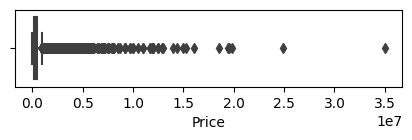

In [59]:
boxPlot('Price')

<Axes: title={'center': 'Price Histogram'}, xlabel='Price', ylabel='Count'>

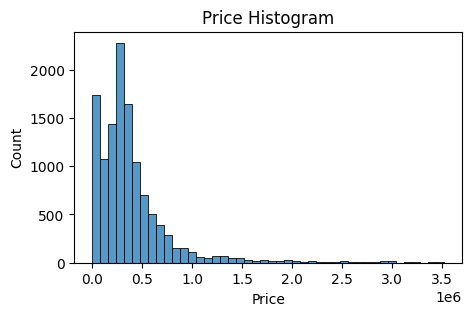

In [33]:
plt.figure(figsize=(5,3))
plt.title('Price Histogram')
sns.histplot(properties['Price'],bins=(range(0,3600000,80000)))

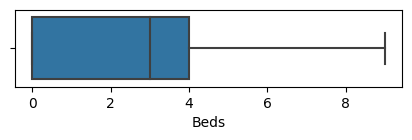

In [38]:

boxPlot('Beds')

<Axes: title={'center': 'Bed Rooms Histogram'}, xlabel='Beds', ylabel='Count'>

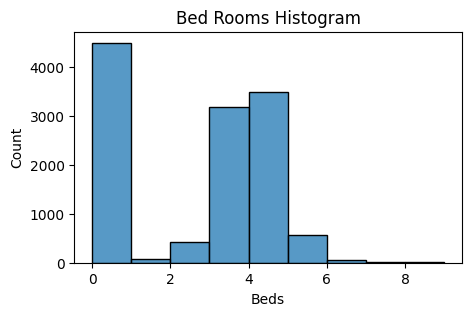

In [34]:
plt.figure(figsize=(5,3))
plt.title('Bed Rooms Histogram')
sns.histplot(x=properties['Beds'], bins=range(0,10))

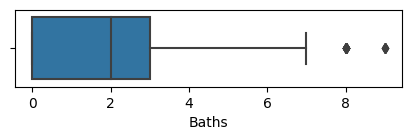

In [15]:
boxPlot('Baths')

<Axes: title={'center': 'Bath Rooms Histogram'}, xlabel='Baths', ylabel='Count'>

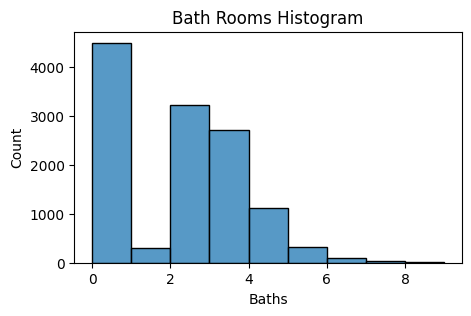

In [36]:
plt.figure(figsize=(5,3))
plt.title('Bath Rooms Histogram')
sns.histplot(properties['Baths'],bins=(range(0,10)))

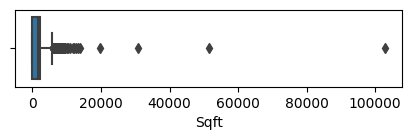

In [60]:
boxPlot('Sqft')

<Axes: title={'center': 'Sqft Histogram'}, xlabel='Sqft', ylabel='Count'>

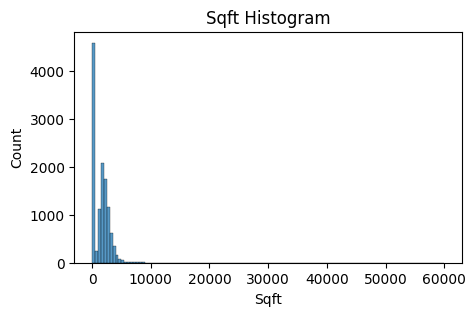

In [3]:
plt.figure(figsize=(5,3))
plt.title('Sqft Histogram')
sns.histplot(properties['Sqft'],bins=(range(0,60001,500)))

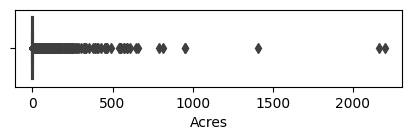

In [61]:
boxPlot('Acres')

/tmp/ipykernel_28501/1186495044.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0,150,20))


[Text(-20.0, 0, '0'),
 Text(0.0, 0, '20'),
 Text(20.0, 0, '40'),
 Text(40.0, 0, '60'),
 Text(60.0, 0, '80'),
 Text(80.0, 0, '100'),
 Text(100.0, 0, '120'),
 Text(120.0, 0, '140')]

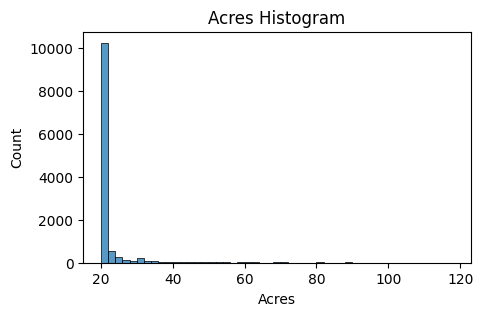

In [57]:
plt.figure(figsize=(5,3))
plt.title('Acres Histogram')
ax = sns.histplot(properties['Acres'],bins=(range(0,100,2)))
ax.set_xticklabels(range(0,150,20))

In [20]:
city = properties.groupby(by='City').count()[['Price']].sort_values(by='Price', ascending=False)
city

,Price
City,
CONROE,2063
CLEVELAND,1149
MONTGOMERY,1085
MAGNOLIA,962
WILLIS,705
...,...
SLENDORA,1
MONT BELVIEU,1
NO CITY,1


In [44]:
def groupBar(df,name):
    plt.figure(figsize=(15,3))
    ax = sns.barplot(data=df, x=df.index, y=df.Price)
    plt.title(f'The Number of Properties for Sale by {name}')
    plt.ylabel('Count')
    plt.xticks(rotation=45, horizontalalignment='right')
    ax.set_xticklabels(labels=df.index,fontsize=6)

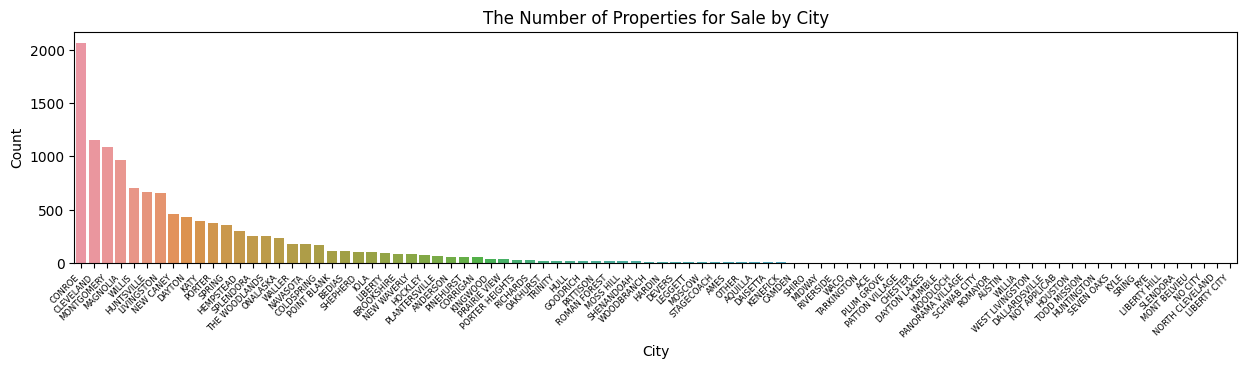

In [45]:
groupBar(city,'City')

In [46]:
zip = properties.groupby(by='ZipCode').count()[['Price']]
zip.sort_values(by='Price', ascending=False, inplace=True)

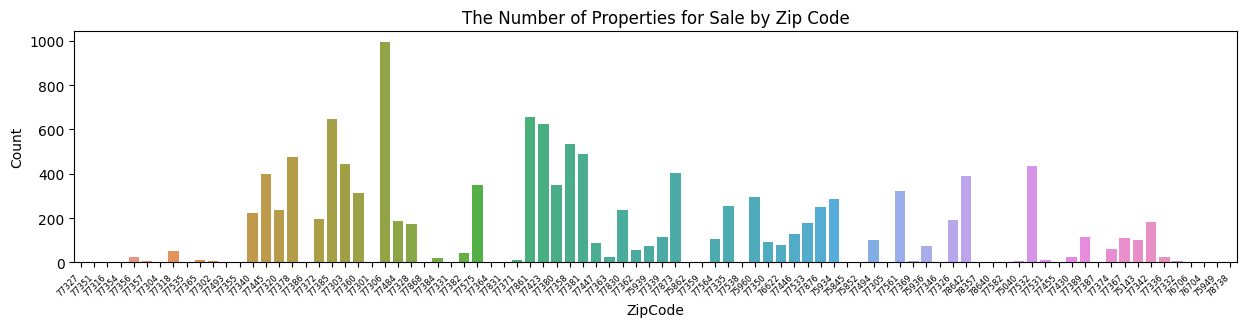

In [47]:
groupBar(zip,'Zip Code')

In [19]:
avg_by_city = properties.groupby(by='City').agg({'Price':'mean'}).round(2).\
    sort_values(by='Price', ascending=False)
avg_by_city

,Price
City,
TODD MISSION,6643350.00
MONT BELVIEU,6545000.00
NO CITY,3246071.00
PRAIRIE VIEW,1718525.68
RICHARDS,1518033.00
...,...
HOUSTON,77000.00
NOT APPLICAB,68900.00
DALLARDSVILLE,28000.00


In [79]:
def groupAvgBar(df,name):
    plt.figure(figsize=(15,3))
    ax = sns.barplot(x=df.index, y=df.Price)
    plt.title(f'The Average Price Per Property by {name}')
    plt.ylabel('Average Price in Millions')
    plt.xticks(rotation=45, horizontalalignment='right')
    ax.set_xticklabels(labels=df.index,fontsize=6)
    

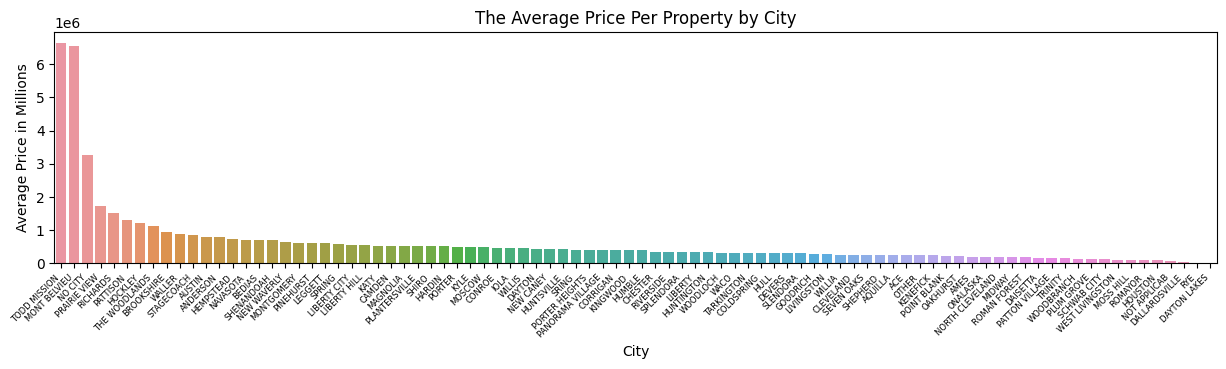

In [80]:
groupAvgBar(avg_by_city,'City')

In [82]:
avg_by_zipcode = properties.groupby(by='ZipCode').agg({'Price':'mean'}).round(2).\
    sort_values(by='Price', ascending=False)
avg_by_zipcode

,Price
ZipCode,
77532,8500000.00
77446,2219495.40
77561,1922149.50
77873,1518033.00
77447,1342211.36
...,...
75040,28500.00
77332,28000.00
77582,17750.00


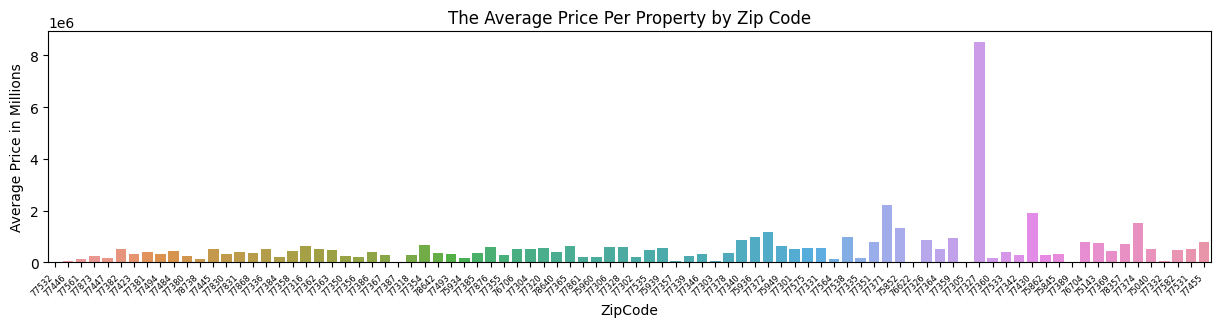

In [83]:
groupAvgBar(avg_by_zipcode,'Zip Code')

In [77]:
def groupMaxBar(df,name):
    plt.figure(figsize=(15,3))
    ax = sns.barplot(x=df.index, y=df.Price)
    plt.title(f'The Maximum Price Per Property by {name}')
    plt.ylabel('Max Price in Millions')
    plt.xticks(rotation=45, horizontalalignment='right')
    ax.set_xticklabels(labels=df.index,fontsize=6)

In [73]:
max_by_city = properties.groupby(by='City').agg({'Price':'max'}).round(2).\
    sort_values(by='Price', ascending=False)
max_by_city

,Price
City,
HEMPSTEAD,35000000
MONTGOMERY,24900000
WALLER,19800000
PRAIRIE VIEW,16000000
NAVASOTA,15293400
...,...
HOUSTON,77000
NOT APPLICAB,68900
DALLARDSVILLE,28000


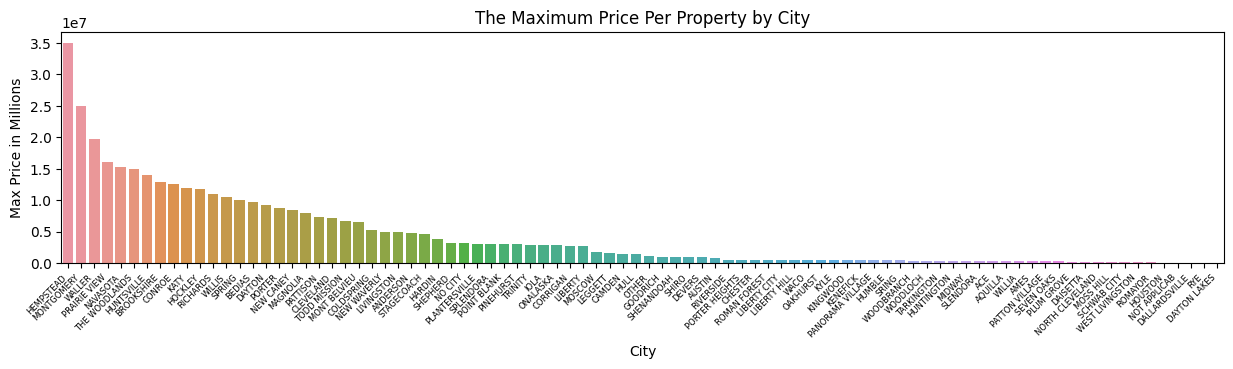

In [78]:
groupMaxBar(max_by_city,'City')

In [85]:
max_by_zipcode = properties.groupby(by='ZipCode').agg({'Price':'max'}).round(2).\
    sort_values(by='Price', ascending=False)
max_by_zipcode

,Price
ZipCode,
77445,35000000
77316,24900000
77484,19800000
77868,15293400
77381,15000000
...,...
75040,28500
77332,28000
77582,17750


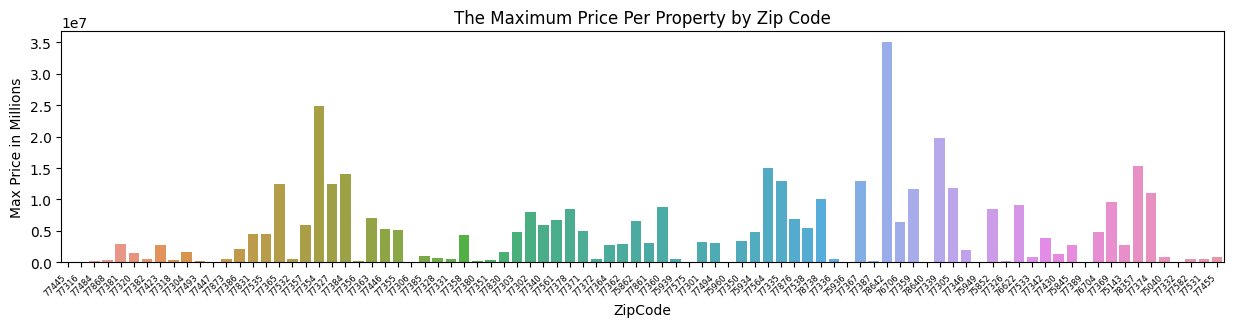

In [86]:
groupMaxBar(max_by_zipcode,'Zip Code')

Loading Phase

In [109]:
properties.to_csv('properties.csv', index=False)

In [5]:
import psycopg2
conn = psycopg2.connect(
    host="localhost",
    database="RealEstateScrapper",
    user="postgres",
    password="unknown")
cursor =  conn.cursor()

print(conn)

<connection object at 0x7f733bb4ec00; dsn: 'user=postgres password=xxx dbname=RealEstateScrapper host=localhost', closed: 0>


In [11]:
from sqlalchemy import create_engine
engine = create_engine('postgresql+psycopg2://postgres:unknown\
@localhost/RealEstateScrapper')
py_conn = engine.connect()
print(py_conn)

In [13]:
properties.to_sql(name='realestate', con=py_conn, if_exists='replace',
          index=False)
conn.commit()

309

In [17]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM realestate ")
row = cursor.fetchall()
for r in row:
    print(r)

(160000, '1-3-73 WINCHESTER ROAD', 'HUNTSVILLE', 'TX', 77340, 0, 0, 0, 2.06)
(95000, '7-23-67 SKY OAK LANE', 'HUNTSVILLE', 'TX', 77340, 0, 0, 0, 1.0)
(419000, '706 QUAIL HOLLOW DR', 'HUNTSVILLE', 'TX', 77340, 3, 3, 2516, 0.0)
(159000, '2-10-17 STAGECOACH CIRCLE', 'HUNTSVILLE', 'TX', 77340, 0, 0, 0, 3.56)
(99900, '5-23-31 RIM ROCK ROAD', 'HUNTSVILLE', 'TX', 77340, 0, 0, 0, 1.54)
(49900, '25 STEAMBOAT RD', 'HUNTSVILLE', 'TX', 77320, 0, 0, 0, 0.54)
(191500, '2511 SYCAMORE AVE', 'HUNTSVILLE', 'TX', 77340, 3, 2, 1491, 0.0)
(191189, 'TBD HADLEY CREEK BEND', 'HUNTSVILLE', 'TX', 77320, 0, 0, 0, 7.99)
(123900, '12-51-22 COPPERLEAF ROAD', 'HUNTSVILLE', 'TX', 77340, 0, 0, 0, 2.0)
(230000, '34 BLYTHE RANCH RD', 'HUNTSVILLE', 'TX', 77320, 5, 3, 2600, 0.0)
(144900, '10-26-33 LONESTAR ROAD', 'HUNTSVILLE', 'TX', 77340, 0, 0, 0, 2.0)
(695000, '8407 STATE HIGHWAY 75 S', 'HUNTSVILLE', 'TX', 77340, 2, 1, 1456, 0.0)
(1045000, '123 BRANDING IRON RD', 'HUNTSVILLE', 'TX', 77340, 4, 5, 4140, 0.0)
(749900, '701